In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [2]:
# ! pip install torch

In [3]:
df = pd.read_csv("BTC-2017min.csv")
# print(df.head(5))
# df = df[:3000]
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df[["date","open","high"]].head(5)
# df.info()
# df=df[0:3]
print(df.size)
print(df)

4730391
              unix                date   symbol      open      high       low  \
0       1514764740 2017-12-31 23:59:00  BTC/USD  13913.28  13913.28  13867.18   
1       1514764680 2017-12-31 23:58:00  BTC/USD  13913.26  13953.83  13884.69   
2       1514764620 2017-12-31 23:57:00  BTC/USD  13908.73  13913.26  13874.99   
3       1514764560 2017-12-31 23:56:00  BTC/USD  13827.00  13908.69  13827.00   
4       1514764500 2017-12-31 23:55:00  BTC/USD  13825.05  13825.05  13825.05   
...            ...                 ...      ...       ...       ...       ...   
525594  1483229100 2017-01-01 00:05:00  BTC/USD    966.43    966.43    966.43   
525595  1483229040 2017-01-01 00:04:00  BTC/USD    966.37    966.37    966.37   
525596  1483228980 2017-01-01 00:03:00  BTC/USD    966.37    966.37    966.37   
525597  1483228920 2017-01-01 00:02:00  BTC/USD    966.16    966.37    966.16   
525598  1483228860 2017-01-01 00:01:00  BTC/USD    966.34    966.34    966.34   

           close  V

array([<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>,
       <AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>],
      dtype=object)

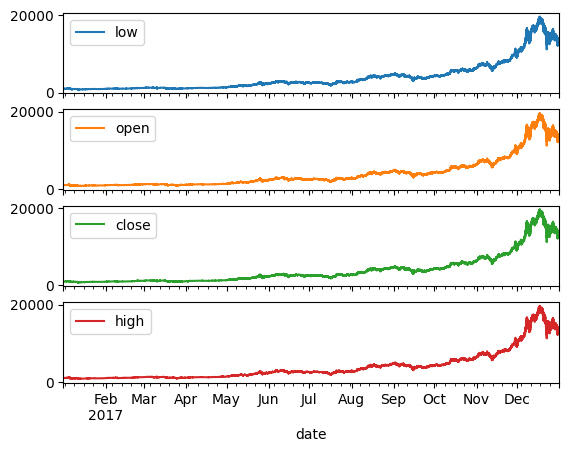

In [4]:
# df.set_index('date')[['low']].plot()
# df['date'].plot()
df.set_index('date')[['low','open','close','high']].plot(subplots=True)

In [5]:
# x = df[['open','close','low','high']]
# y = df[['open']]
# # x[0:20]
# # y[0:20]

In [6]:
def get_set(dataset, step):
    data_x, data_y = [],[]
    for i in range(len(dataset)-step-10):
        a = dataset[i:(i+step),0]
        data_x.append(a)
        data_y.append(dataset[i + step:i + step + 10, 0])
    return np.array(data_x), np.array(data_y)
        

In [7]:
np.random.seed(42)

obs = np.arange(1, len(df) + 1, 1)

OHLC_avg = df[['high', 'low', 'close','open']].mean(axis = 1)
# print(OHLC_avg)
HLC_avg = df[['high', 'low', 'close']].mean(axis = 1)
close_val = df[['close']]


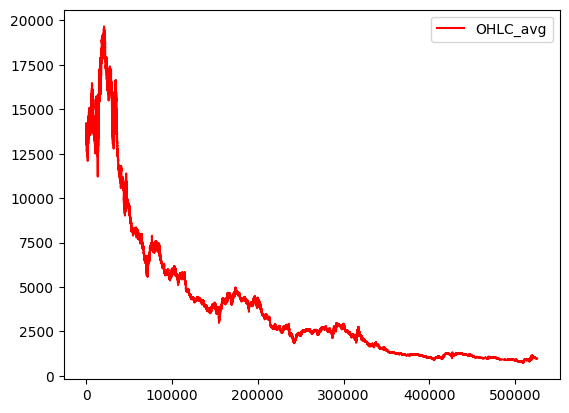

In [8]:
import matplotlib.pyplot as plt

plt.plot(obs,OHLC_avg,'r',label='OHLC_avg')
# plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
# plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

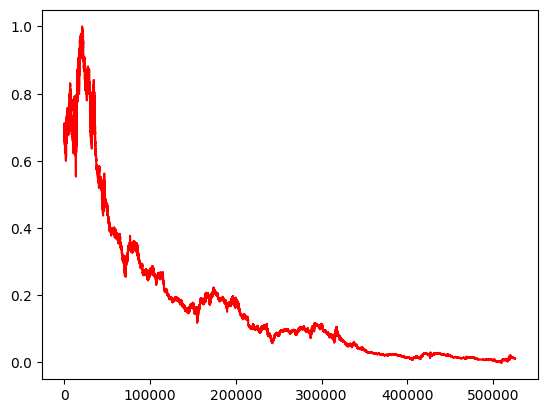

In [9]:
# PREPARATION OF TIME SERIES DATASE
from sklearn.preprocessing import MinMaxScaler
OHLC_avg = np.reshape(OHLC_avg.values,(len(OHLC_avg),1))
scaler = MinMaxScaler(feature_range=(0,1))
OHLC_avg = scaler.fit_transform(OHLC_avg)
# print(OHLC_avg)
plt.plot(obs,OHLC_avg,'r',label='OHLC_avg')
plt.show()

In [10]:
# # TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.9)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC= OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]
# print(len(OHLC_avg))
# print(len(test_OHLC))
# print(len(train_OHLC))

# train_len = int(len(OHLC_avg) * 0.8)  # 80% for training
# val_len = int(len(OHLC_avg) * 0.1)    # 10% for validation
# # test_len = len(OHLC_avg) - train_len - val_len  # Remaining for testing

# train_OHLC = OHLC_avg[:train_len, :]
# val_OHLC = OHLC_avg[train_len:train_len + val_len, :]
# test_OHLC = OHLC_avg[train_len + val_len:, :]

In [11]:
from torch.autograd import Variable
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
step = 20
# Variable(torch.Tensor(np.array(x)))
trainX, trainY = get_set(train_OHLC, step)
testX, testY = get_set(test_OHLC, step)

indices = np.arange(len(trainX))
np.random.shuffle(indices)

# Use the shuffled indices to shuffle trainX and trainY
trainX = trainX[indices]
trainY = trainY[indices]

trainX = Variable(torch.Tensor(np.array(trainX)))
trainY = Variable(torch.Tensor(np.array(trainY)))
testX  = Variable(torch.Tensor(np.array(testX)))
testY  =Variable(torch.Tensor(np.array(testY)))

In [12]:
# print(trainX)

In [13]:
# RESHAPING TRAIN AND TEST DATA
# converting tuple into array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

split_ratio = 0.8  # 80% for training, 20% for validation

split_index = int(len(trainX) * split_ratio)

train_X = trainX[:split_index]
val_X = trainX[split_index:]

train_Y = trainY[:split_index]
val_Y = trainY[split_index:]
# step_size = 1
# print(train_X)
# print(trainX.shape)
print(trainX.size(0))

473009


In [14]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = step

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)  # Adjust output size

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Take the last output and feed it to the FC layer
        return out

In [15]:
num_epochs = 2000
learning_rate = 0.01

input_size = step
hidden_size = 2
num_layers = 1

num_classes = 10

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # correct upto training but negative deflection at test data
# optimizer = torch.optim.Adadelta(lstm.parameters(), lr=learning_rate) # straight line
# optimizer = torch.optim.Adagrad(lstm.parameters(), lr=learning_rate) # straight line
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate) # straight line
# optimizer = torch.optim.Adamax(lstm.parameters(), lr=learning_rate) #overfitting correct upto training but very much at test data


In [16]:
best_val_loss = float('inf')
for epoch in range(num_epochs):
    
    outputs = lstm(train_X)
#     outputs = outputs.squeeze()
    optimizer.zero_grad()
#     target = target.unsqueeze(1)
    
    loss = criterion(outputs.squeeze(), train_Y)
    loss.backward()
    
    optimizer.step()
#     print(outputs.shape)
#     print(train_Y.shape)
    
    
    out_val = lstm(val_X)
#     val_X = val_X.squeeze()
    val_loss = criterion(out_val.squeeze(), val_Y)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save model checkpoint
        torch.save(lstm.state_dict(), 'best_model1.pth')
    
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f, val_loss: %1.5f" % (epoch, loss.item(), val_loss.item()))

Epoch: 0, loss: 0.19766, val_loss: 0.18838
Epoch: 100, loss: 0.00377, val_loss: 0.00357
Epoch: 200, loss: 0.00023, val_loss: 0.00023
Epoch: 300, loss: 0.00008, val_loss: 0.00008
Epoch: 400, loss: 0.00005, val_loss: 0.00004
Epoch: 500, loss: 0.00003, val_loss: 0.00003
Epoch: 600, loss: 0.00003, val_loss: 0.00003
Epoch: 700, loss: 0.00002, val_loss: 0.00002
Epoch: 800, loss: 0.00002, val_loss: 0.00002
Epoch: 900, loss: 0.00002, val_loss: 0.00002
Epoch: 1000, loss: 0.00002, val_loss: 0.00002
Epoch: 1100, loss: 0.00002, val_loss: 0.00002
Epoch: 1200, loss: 0.00002, val_loss: 0.00001
Epoch: 1300, loss: 0.00001, val_loss: 0.00001
Epoch: 1400, loss: 0.00001, val_loss: 0.00001
Epoch: 1500, loss: 0.00001, val_loss: 0.00001
Epoch: 1600, loss: 0.00001, val_loss: 0.00001
Epoch: 1700, loss: 0.00001, val_loss: 0.00001
Epoch: 1800, loss: 0.00001, val_loss: 0.00001
Epoch: 1900, loss: 0.00001, val_loss: 0.00001


In [17]:
lstm.eval()
lstm.load_state_dict(torch.load('best_model1.pth'))
# print(best_val_loss)
# train_predict = tuple(lstm(testX).detach().numpy())
test_predict = tuple(lstm(testX).detach().numpy())
train_predict = tuple(lstm(train_X).detach().numpy())

# testY = tuple(testY)

Test RMSE: 0.00

Model test accuracy: 16.78%



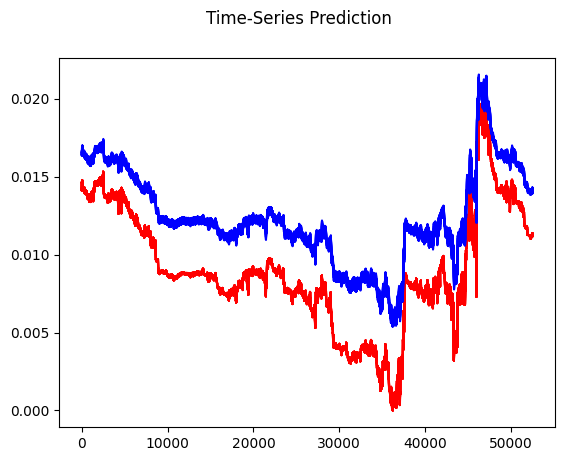

In [18]:
# print(type(train_predict))
# print(type(testY))
# print(testY)
# print(testY)
# DE-NORMALIZING FOR PLOTTING 
# trainPredict = scaler.inverse_transform(train_predict)
# trainY = scaler.inverse_transform(trainY)
# testPredict = scaler.inverse_transform(testPredict)
# test2Y = scaler.inverse_transform(testY)


# plt.axvline(x=len(trainX))

from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY,test_predict))
print('Test RMSE: %.2f' % (testScore))

r2 = r2_score(testY,test_predict)
# print(r2)
print(f'\nModel test accuracy: {r2*100:.2f}%\n')

plt.plot(testY,c='r')
plt.plot(test_predict,c='b')
plt.suptitle('Time-Series Prediction')
plt.show()

In [19]:
# test_predict = tuple(lstm(testX[-1]).detach().numpy())
print(testX[-1])
print(testY[-1])
test_prd2 = lstm(testX[-1].unsqueeze(1)).squeeze()

tensor([[0.0113, 0.0113, 0.0113, 0.0112, 0.0112, 0.0112, 0.0112, 0.0113, 0.0113,
         0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113,
         0.0113, 0.0113]])
tensor([0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113, 0.0113,
        0.0113])


In [20]:
print(test_prd2.shape)
print(testY[-1].shape)
print(test_prd2)

torch.Size([10])
torch.Size([10])
tensor([0.0142, 0.0141, 0.0142, 0.0140, 0.0142, 0.0140, 0.0140, 0.0142, 0.0141,
        0.0142], grad_fn=<SqueezeBackward0>)


In [ ]:
# test_prd2 = lstm(testX[-1])

tensor = torch.randn(10)

# numpy_array = tensor.numpy()

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[-1].detach().numpy(),test_prd2.detach().numpy()))
print('Test RMSE: %.2f' % (testScore))

r2 = r2_score(testY[-1].detach().numpy(),test_prd2.detach().numpy())
# print(r2)
print(f'\nModel test accuracy: {r2*100:.2f}%\n')

plt.plot(testY[-1].detach().numpy(),c='r')
plt.plot(test_prd2.detach().numpy(),c='b')
plt.suptitle('Time-Series Prediction')
plt.show()

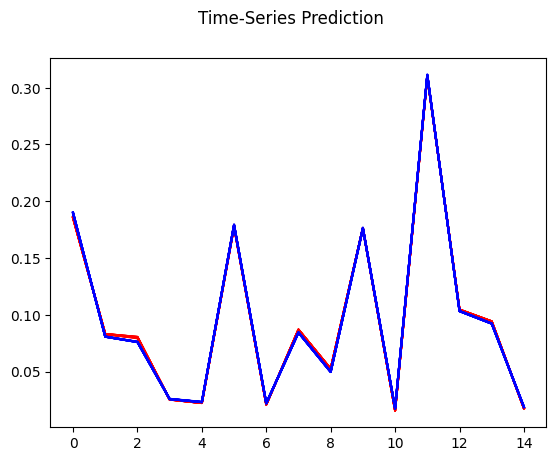

In [22]:
plt.plot(trainY[:15],c='r')
plt.plot(train_predict[:15],c='b')
plt.suptitle('Time-Series Prediction')
plt.show()

In [23]:
# train_predictions = np.array(train_predict).reshape(-1, 5)
# test_predictions = np.array(test_predict).reshape(-1, 5)
# print(train_predictions[0:5])
# print(test_predictions[0:5])

train_predictions = np.array(train_predict).reshape(np.array(train_predict).shape[0], -1)
test_predictions = np.array(test_predict).reshape(np.array(test_predict).shape[0], -1)

In [24]:
# train_predict[0:5]
# train_predictions[0:5]

In [25]:
import xgboost as xgb

# Concatenate LSTM predictions with original features
X_train_xgb = np.hstack([train_X.squeeze().numpy(), train_predictions])
X_test_xgb = np.hstack([testX.squeeze().numpy(), test_predictions])
print(train_X.squeeze().numpy().shape)
print(train_predictions.shape)

# Convert target arrays to DMatrix
dtrain = xgb.DMatrix(X_train_xgb, label=train_Y.numpy())
dtest = xgb.DMatrix(X_test_xgb, label=testY.numpy())

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'test')], early_stopping_rounds=50)


(378407, 20)
(378407, 10)
[0]	test-rmse:0.16019
[1]	test-rmse:0.14463
[2]	test-rmse:0.13056
[3]	test-rmse:0.11796
[4]	test-rmse:0.10657
[5]	test-rmse:0.09636
[6]	test-rmse:0.08711
[7]	test-rmse:0.07880
[8]	test-rmse:0.07128
[9]	test-rmse:0.06451
[10]	test-rmse:0.05837
[11]	test-rmse:0.05282
[12]	test-rmse:0.04787
[13]	test-rmse:0.04338
[14]	test-rmse:0.03932
[15]	test-rmse:0.03569
[16]	test-rmse:0.03245
[17]	test-rmse:0.02949
[18]	test-rmse:0.02679
[19]	test-rmse:0.02434
[20]	test-rmse:0.02217
[21]	test-rmse:0.02020
[22]	test-rmse:0.01840
[23]	test-rmse:0.01679
[24]	test-rmse:0.01534
[25]	test-rmse:0.01403
[26]	test-rmse:0.01285
[27]	test-rmse:0.01181
[28]	test-rmse:0.01086
[29]	test-rmse:0.01000
[30]	test-rmse:0.00923
[31]	test-rmse:0.00855
[32]	test-rmse:0.00792
[33]	test-rmse:0.00738
[34]	test-rmse:0.00687
[35]	test-rmse:0.00642
[36]	test-rmse:0.00602
[37]	test-rmse:0.00566
[38]	test-rmse:0.00534
[39]	test-rmse:0.00506
[40]	test-rmse:0.00481
[41]	test-rmse:0.00458
[42]	test-rmse:0.0

[345]	test-rmse:0.00275
[346]	test-rmse:0.00275
[347]	test-rmse:0.00275
[348]	test-rmse:0.00275
[349]	test-rmse:0.00275
[350]	test-rmse:0.00275
[351]	test-rmse:0.00275
[352]	test-rmse:0.00275
[353]	test-rmse:0.00275
[354]	test-rmse:0.00275
[355]	test-rmse:0.00275
[356]	test-rmse:0.00275
[357]	test-rmse:0.00275
[358]	test-rmse:0.00275
[359]	test-rmse:0.00275
[360]	test-rmse:0.00275
[361]	test-rmse:0.00275
[362]	test-rmse:0.00275
[363]	test-rmse:0.00275
[364]	test-rmse:0.00275
[365]	test-rmse:0.00275
[366]	test-rmse:0.00275
[367]	test-rmse:0.00275
[368]	test-rmse:0.00275
[369]	test-rmse:0.00275
[370]	test-rmse:0.00275
[371]	test-rmse:0.00275
[372]	test-rmse:0.00275
[373]	test-rmse:0.00275
[374]	test-rmse:0.00275
[375]	test-rmse:0.00275
[376]	test-rmse:0.00275
[377]	test-rmse:0.00275
[378]	test-rmse:0.00275
[379]	test-rmse:0.00275
[380]	test-rmse:0.00275
[381]	test-rmse:0.00275
[382]	test-rmse:0.00275
[383]	test-rmse:0.00275
[384]	test-rmse:0.00275
[385]	test-rmse:0.00275
[386]	test-rmse:

[687]	test-rmse:0.00274
[688]	test-rmse:0.00274
[689]	test-rmse:0.00274
[690]	test-rmse:0.00274
[691]	test-rmse:0.00274
[692]	test-rmse:0.00274
[693]	test-rmse:0.00274
[694]	test-rmse:0.00274
[695]	test-rmse:0.00274
[696]	test-rmse:0.00274
[697]	test-rmse:0.00274
[698]	test-rmse:0.00274
[699]	test-rmse:0.00274
[700]	test-rmse:0.00274
[701]	test-rmse:0.00274
[702]	test-rmse:0.00274
[703]	test-rmse:0.00274
[704]	test-rmse:0.00274
[705]	test-rmse:0.00274
[706]	test-rmse:0.00274
[707]	test-rmse:0.00274
[708]	test-rmse:0.00274
[709]	test-rmse:0.00274
[710]	test-rmse:0.00274
[711]	test-rmse:0.00274
[712]	test-rmse:0.00274
[713]	test-rmse:0.00274
[714]	test-rmse:0.00274
[715]	test-rmse:0.00274
[716]	test-rmse:0.00274
[717]	test-rmse:0.00274
[718]	test-rmse:0.00274
[719]	test-rmse:0.00274
[720]	test-rmse:0.00274
[721]	test-rmse:0.00274
[722]	test-rmse:0.00274
[723]	test-rmse:0.00274
[724]	test-rmse:0.00274
[725]	test-rmse:0.00274
[726]	test-rmse:0.00274
[727]	test-rmse:0.00274
[728]	test-rmse:

RMSE: 0.0027363605331629515

Model test accuracy: -38.69%



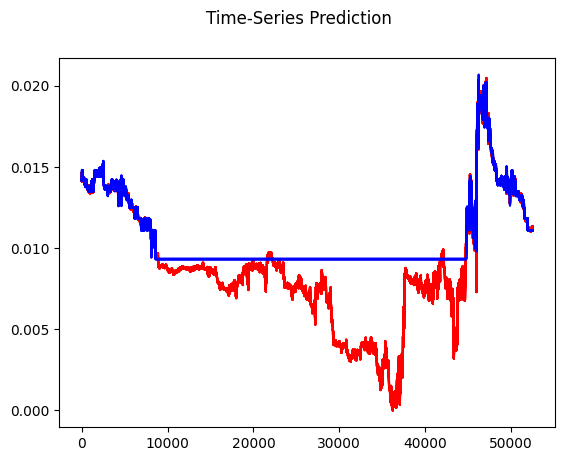

In [26]:
xgb_predictions = bst.predict(dtest)
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY.numpy(), xgb_predictions))
print(f"RMSE: {rmse}")

r2 = r2_score(xgb_predictions,testY.numpy())
# print(r2)
print(f'\nModel test accuracy: {r2*100:.2f}%\n')


plt.plot(testY.numpy(),c='r')
plt.plot(xgb_predictions,c='b')
plt.suptitle('Time-Series Prediction')
plt.show()

In [27]:
# Get predictions from LSTM for validation set
# val_predictions = tuple(lstm(val_X).detach().numpy())

# # Reshape LSTM predictions to match the shape of val_X
# val_predictions_reshaped = np.array(val_predictions).reshape(-1, 1)

# # Concatenate LSTM predictions with original features
# val_X_with_predictions = np.hstack([val_X.squeeze().numpy(), val_predictions_reshaped])
# # print(val_X_with_predictions.shape)

# # Convert to DMatrix
# dtest_val = xgb.DMatrix(val_X_with_predictions)
# xgb_val_pred = bst.predict(dtest_val)
# print(xgb_val_pred.shape)
# print(val_Y.numpy().shape)
# print(val_X.shape)
# print(val_X.squeeze().numpy().shape)
# print(val_X_with_predictions.shape) ---> (5398, 10) + (5398, 1) = (5398, 11)

In [28]:
# rmse = np.sqrt(mean_squared_error(val_Y.numpy(), xgb_val_pred))
# print(f"RMSE: {rmse}")

# r2 = r2_score(xgb_val_pred,val_Y.numpy())
# # print(r2)
# print(f'\nModel test accuracy: {r2*100:.2f}%\n')

# plt.plot(val_Y.numpy()[:50],c='r')
# plt.plot(xgb_val_pred[:50],c='b')
# plt.suptitle('Time-Series Prediction')
# plt.show()

In [ ]:
# Reshape test_pr2 to have dimensions (1, 10)
test_pr2_reshaped = test_prd2.detach().numpy().reshape(1, -1)

# Reshape testX[-1] to have dimensions (1, 20)
testX_reshaped = testX[-1].squeeze().numpy().reshape(1, -1)

# Concatenate LSTM predictions with original features
test_X_with_predictions = np.hstack([testX_reshaped, test_pr2_reshaped])

print(test_X_with_predictions.shape)


# Convert to DMatrix
dtest_val = xgb.DMatrix(test_X_with_predictions)
xgb_val_pred2 = bst.predict(dtest_val).flatten()


true_values = testY[-1].detach().numpy().reshape(1, -1).flatten()

rmse = np.sqrt(mean_squared_error(true_values, xgb_val_pred2))
print(f"RMSE: {rmse}")

r2 = r2_score(true_values, xgb_val_pred2)
print(f'\nModel test accuracy: {r2*100:.2f}%\n')

plt.plot(true_values.flatten(), c='r')
plt.plot(xgb_val_pred2.flatten(), c='b')
plt.suptitle('Time-Series Prediction')
plt.show()
# print(true_values, xgb_val_pred2)
